# Reduce the number of H$\mathrm{_2}$O lines using pseudo-line generator (plg)
Tako Ishikawa  
last update: 2022/05/10   
created: : 2022/05/05　　

In [2]:
import os; os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
import numpy as np
import jax.numpy as jnp
from exojax.spec import plg
from exojax.spec import moldb, contdb, molinfo
from exojax.spec.rtransfer import nugrid
from exojax.spec import initspec
import matplotlib.pyplot as plt
import time
import tqdm
import copy
#path_fig = '/home/tako/Dropbox/tmpfig/'

In [3]:
#Parameter to make elower grid
Nelower = 7
#Ncrit = 0 #10
Tgue = 3000. 
errTgue = 500.

In [4]:
wls, wll, nugrid_res = 15541, 15551, 0.05
nus, wav, reso = nugrid(wls, wll, int((wll-wls)/nugrid_res), unit="AA", xsmode="modit")
mdb_orig = moldb.MdbExomol('.database/H2O/1H2-16O/POKAZATEL/', nus, \
                           crit=0, Ttyp=Tgue) #1.e-40
mdb = copy.deepcopy(mdb_orig)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)
molmassH2O = molinfo.molmass("H2O")
print("Nline=",len(mdb_orig.A)) #chk

xsmode assumes ESLOG: mode= modit
Background atmosphere:  H2
Error: Couldn't download .broad file and save.
Note: Couldn't find the hdf5 format. We convert data to the hdf5 format. After the second time, it will become much faster.
Reading transition file
Note: Couldn't find the hdf5 format. We convert data to the hdf5 format. After the second time, it will become much faster.
.broad is used.
Broadening code level= a1
default broadening parameters are used for  12  J lower states in  63  states
H2-H2
Nline= 1418720


In [5]:
#To save computation time, let us use only the middle 1 Å width to optimize coefTgue
assess_width = 1. #Note that too narrow might cause a ValueError. (#Cause unspecified...)
nusc, wavc, resoc = nugrid( (wll+wls-assess_width)/2, (wll+wls+assess_width)/2, 20, unit="AA", xsmode="modit")
mdbc = moldb.MdbExomol('.database/H2O/1H2-16O/POKAZATEL/', nusc)

ts = time.time()
coefTgue = plg.optimize_coefTgue(Tgue, nusc, mdbc, molmassH2O, errTgue)
#coefTgue = plg.optimize_coefTgue(Tgue, nus, mdb_orig, molmassH2O) #373.4 sec for 1418720 lines.
te = time.time()
print(te-ts, "sec for", len(mdbc.A), "lines,  coefTgue =", coefTgue)

xsmode assumes ESLOG: mode= modit
Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  10  J lower states in  61  states
81.73206853866577 sec for 141794 lines,  coefTgue = 0.7321634700252116


In [6]:
#Initialization of modit
cnu,indexnu,R,pmarray=initspec.init_modit(mdb.nu_lines,nus)
cnu_orig = copy.deepcopy(cnu)
indexnu_orig = copy.deepcopy(indexnu)

#make grid of gamma and index_gamma
gammaL_set=mdb.alpha_ref+mdb.n_Texp*(1j) #complex value
gammaL_set_unique=np.unique(gammaL_set)
Ngamma=np.shape(gammaL_set_unique)[0]
index_gamma=np.zeros_like(mdb.alpha_ref,dtype=int)
alpha_ref_grid=gammaL_set_unique.real
n_Texp_grid=gammaL_set_unique.imag
for j,a in tqdm.tqdm(enumerate(gammaL_set_unique)):
    index_gamma=np.where(gammaL_set==a,j,index_gamma)        

116it [00:00, 214.46it/s]


In [7]:
reshape = False
ts = time.time()
qlogsij0, qcnu, num_unique, elower_grid, frozen_mask, nonzeropl_mask = plg.plg_elower_addcon(\
    index_gamma, Ngamma, cnu, indexnu, nus, mdb, Tgue, errTgue, \
    Nelower=Nelower, reshape=reshape, coefTgue=coefTgue)    
te = time.time()
print(te-ts, "sec")
print("elower_grid", elower_grid)

if reshape:
    num_unique = np.array(num_unique, dtype = float)
    num_unique[num_unique<Ncrit] = None
    fig = plt.figure(figsize = (10, 4.5))
    ax = fig.add_subplot(311)
    c = plt.imshow(num_unique[0, :, :].T)
    #    c = plt.imshow(np.sum(num_unique[:, :, :], axis = 0).T)
    plt.colorbar(c, shrink = 0.2)
    ax.set_aspect(0.1/ax.get_data_ratio())                
    ax = fig.add_subplot(312)
    c = plt.imshow(qlogsij0[0, :, :].T)
    plt.colorbar(c, shrink = 0.2)
    ax.set_aspect(0.1/ax.get_data_ratio())
    plt.show()
    import sys
    sys.exit()
Nnugrid = len(nus)

mdb, cnu, indexnu = plg.gather_lines(mdb, Ngamma, Nnugrid, Nelower, nus, cnu, indexnu, qlogsij0, qcnu, elower_grid, alpha_ref_grid, n_Texp_grid, frozen_mask, nonzeropl_mask)


# of original lines: 1418720
# of unfrozen lines: 18485
# of frozen lines: 1400235
# of pseudo lines: 2186
# of total lines: 20671
# compression: 0.014570175933235592
1.5991146564483643 sec
elower_grid [  487.13418579 34299.58533295 34460.80949652 34555.11958642
 34622.0336601  34673.93624793 34716.34375   ]


## Check using the output mdb and compare it with the original 

In [8]:
from exojax.spec import rtransfer as rt
from exojax.spec import modit
from exojax.spec.modit import setdgm_exomol
from exojax.spec.rtransfer import rtrun, dtauM, dtauCIA
from exojax.spec import planck, response

#atm
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR

Pref=1.0 #bar
ONEARR=np.ones_like(Parr)

# Precomputing gdm_ngammaL
fT = lambda T0,alpha: T0[:,None]*(Parr[None,:]/Pref)**alpha[:,None]
T0_test=np.array([Tgue-300.,Tgue+300.,Tgue-300.,Tgue+300.])
alpha_test=np.array([0.2,0.2,0.05,0.05])
res=0.2
dgm_ngammaL=setdgm_exomol(mdb,fT,Parr,R,molmassH2O,res,T0_test,alpha_test)
dgm_ngammaL_orig = setdgm_exomol(mdb_orig, fT, Parr, R, molmassH2O, res, T0_test, alpha_test)

#a core driver
def frun(Tarr,MMR_,Mp,Rp,u1,u2,RV,vsini):
    g=2478.57730044555*Mp/Rp**2
    SijM_,ngammaLM_,nsigmaDl_=modit.exomol(mdb,Tarr,Parr,R,molmassH2O)
    xsm_=modit.xsmatrix(cnu,indexnu,R,pmarray,nsigmaDl_,ngammaLM_,SijM_,nus,dgm_ngammaL)
    #abs is used to remove negative values in xsv
    dtaum=dtauM(dParr,jnp.abs(xsm_),MMR_*ONEARR,molmassH2O,g)
    #CIA
    dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)
    dtau=dtaum+dtaucH2H2
    sourcef = planck.piBarr(Tarr,nus)
    F0=rtrun(dtau,sourcef)
    Frot=response.rigidrot(nus,F0,vsini,u1,u2)
    #mu=response.ipgauss_sampling(nusd,nus,Frot,beta_inst,RV)
    mu=Frot
    return mu
def frun_orig(Tarr, MMR_, Mp, Rp, u1, u2, RV, vsini):
    g = 2478.57730044555*Mp/Rp**2
    SijM_, ngammaLM_, nsigmaDl_ = modit.exomol(mdb_orig, Tarr, Parr, R, molmassH2O)
    xsm_ = modit.xsmatrix(cnu_orig, indexnu_orig, R, pmarray, nsigmaDl_, ngammaLM_, SijM_, nus, dgm_ngammaL_orig)
    #abs is used to remove negative values in xsv
    dtaum = dtauM(dParr, jnp.abs(xsm_), MMR_*ONEARR, molmassH2O, g)
    #CIA
    dtaucH2H2 = dtauCIA(nus, Tarr, Parr, dParr, vmrH2, vmrH2, mmw, g, cdbH2H2.nucia, cdbH2H2.tcia, cdbH2H2.logac)
    dtau = dtaum+dtaucH2H2
    sourcef  =  planck.piBarr(Tarr, nus)
    F0 = rtrun(dtau, sourcef)
    Frot = response.rigidrot(nus, F0, vsini, u1, u2)
    #mu = response.ipgauss_sampling(nusd, nus, Frot, beta_inst, RV)
    mu = Frot
    return mu


In [9]:
#Example with GJ699 parameters (0.1863 R_sun, 0.155 M_sun from Mann+2015)
MpMd = 0.155 *1.99e33/1.90e30
RpMd = 0.186 *6.96e10/6.99e9  
MMR_rough = 0.001
plotTF = False

#Test with other parameters
#MpMd = 33.2; RpMd = 0.88; MMR_rough = 0.0059; plotTF=False
#MpMd = 41.; RpMd = 1.; MMR_rough = 0.001; plotTF=False

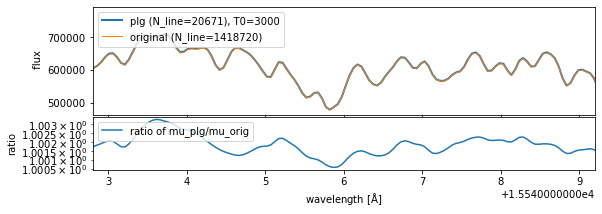

In [10]:
Tarr = Tgue*(Parr/Pref)**0.1
mu=frun(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
mu_orig = frun_orig(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
#plt.plot(wav[::-1],mu)
#plt.plot(wavmic,flux,alpha=0.5,color="C2",label="petit?")
#plt.savefig(path_fig+"h2oplg_Tguefunc.pdf")

llow, lhigh, tip = 15543, 15549, 0.2

fig=plt.figure(figsize=(9,3))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)

plt.plot(wav[::-1], mu, label=f"plg (N_line={len(mdb.A):>5}), T0={int(Tgue):>4}", lw=2.0)
plt.plot(wav[::-1], mu_orig, '-', label=f"original (N_line={len(mdb_orig.A):>5})", lw=1.0)

plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.legend(loc="upper left")
plt.ylabel(" flux",fontsize=10)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')

ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(wav[::-1], mu/mu_orig, label=f"ratio of mu_plg/mu_orig")
plt.yscale("log")
plt.ylabel("ratio",fontsize=10)
plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.legend(loc="upper left")

if plotTF:
    plt.savefig(path_fig + "h2oplg_tutorial.pdf", bbox_inches="tight")#, pad_inches=0.0)
plt.show()

## Additional check (Tshift)
Does it matter if the actual temperatures deviates from Tgue?

2500.0


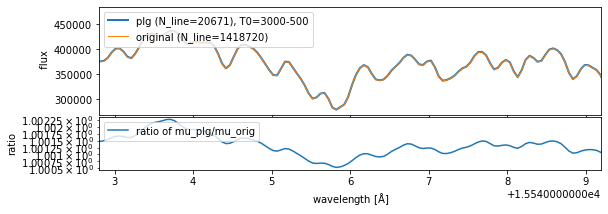

In [11]:
Tshift = -errTgue
print(Tgue + Tshift)

Tarr = (Tgue+Tshift)*(Parr/Pref)**0.1
mu=frun(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
mu_orig = frun_orig(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)

fig=plt.figure(figsize=(9,3))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)

plt.plot(wav[::-1], mu, label=f"plg (N_line={len(mdb.A):>5}), T0={int(Tgue):>4}{int(Tshift):+}", lw=2.0)
plt.plot(wav[::-1], mu_orig, '-', label=f"original (N_line={len(mdb_orig.A):>5})", lw=1.0)

plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.legend(loc="upper left")
plt.ylabel(" flux",fontsize=10)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')

ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(wav[::-1], mu/mu_orig, label=f"ratio of mu_plg/mu_orig")
plt.yscale("log")
plt.ylabel("ratio",fontsize=10)
plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.legend(loc="upper left")

if plotTF:
    plt.savefig(path_fig + f"h2oplg_tutorial_Tshift{int(Tshift):+}.pdf", bbox_inches="tight")#, pad_inches=0.0)
plt.show()

3500.0


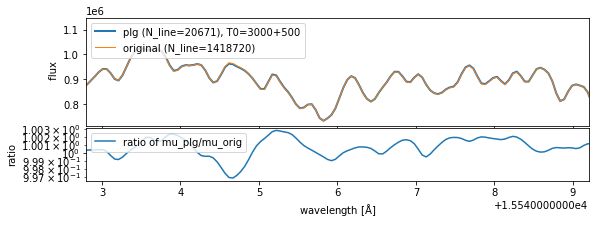

In [12]:
Tshift = +errTgue
print(Tgue + Tshift)

Tarr = (Tgue+Tshift)*(Parr/Pref)**0.1
mu=frun(Tarr,MMR_=MMR_rough,Mp=MpMd, Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
mu_orig = frun_orig(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)

fig=plt.figure(figsize=(9,3))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)

plt.plot(wav[::-1], mu, label=f"plg (N_line={len(mdb.A):>5}), T0={int(Tgue):>4}{int(Tshift):+}", lw=2.0)
plt.plot(wav[::-1], mu_orig, '-', label=f"original (N_line={len(mdb_orig.A):>5})", lw=1.0)

plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.legend(loc="upper left")
plt.ylabel(" flux",fontsize=10)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')

ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(wav[::-1], mu/mu_orig, label=f"ratio of mu_plg/mu_orig")
plt.yscale("log")
plt.ylabel("ratio",fontsize=10)
plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.legend(loc="upper left")

if plotTF:
    plt.savefig(path_fig + f"h2oplg_tutorial_Tshift{int(Tshift):+}.pdf", bbox_inches="tight")#, pad_inches=0.0)
plt.show()